In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 128

In [3]:
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [4]:
style_img = image_loader("../data/images/kawase.png")[:, :3]
style_img = image_loader("../data/images/monnet.png")[:, :3]
content_img = image_loader("../data/images/dance.png")[:, :3]


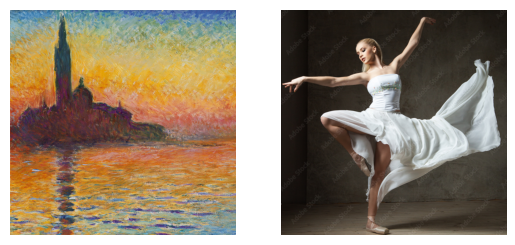

In [5]:
plt.subplot(1, 2, 1)
plt.imshow(style_img[0].cpu().numpy().transpose(1, 2, 0))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(content_img[0].cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

In [6]:
model = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [7]:
style_img.shape, content_img.shape

(torch.Size([1, 3, 512, 512]), torch.Size([1, 3, 512, 512]))

In [8]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = mean.clone().detach().view(-1, 1, 1).to(device)
        self.std = std.clone().detach().view(-1, 1, 1).to(device)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std


In [36]:
pipeline = nn.Sequential()
pipeline.add_module('normalization', Normalization(cnn_normalization_mean, cnn_normalization_std))
for i in range(0, 29):
    pipeline.add_module('layer_{}'.format(i), model[i])
pipeline = pipeline.to(device)

In [37]:
pipeline

Sequential(
  (normalization): Normalization()
  (layer_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_1): ReLU(inplace=True)
  (layer_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_3): ReLU(inplace=True)
  (layer_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer_5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_6): ReLU(inplace=True)
  (layer_7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_8): ReLU(inplace=True)
  (layer_9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer_10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_11): ReLU(inplace=True)
  (layer_12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_13): ReLU(inplace=True)
  (layer_14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_15): ReLU(

In [38]:
(style_img).shape

torch.Size([1, 3, 512, 512])

In [48]:
features = pipeline(style_img)

In [49]:
features.shape

torch.Size([1, 512, 32, 32])

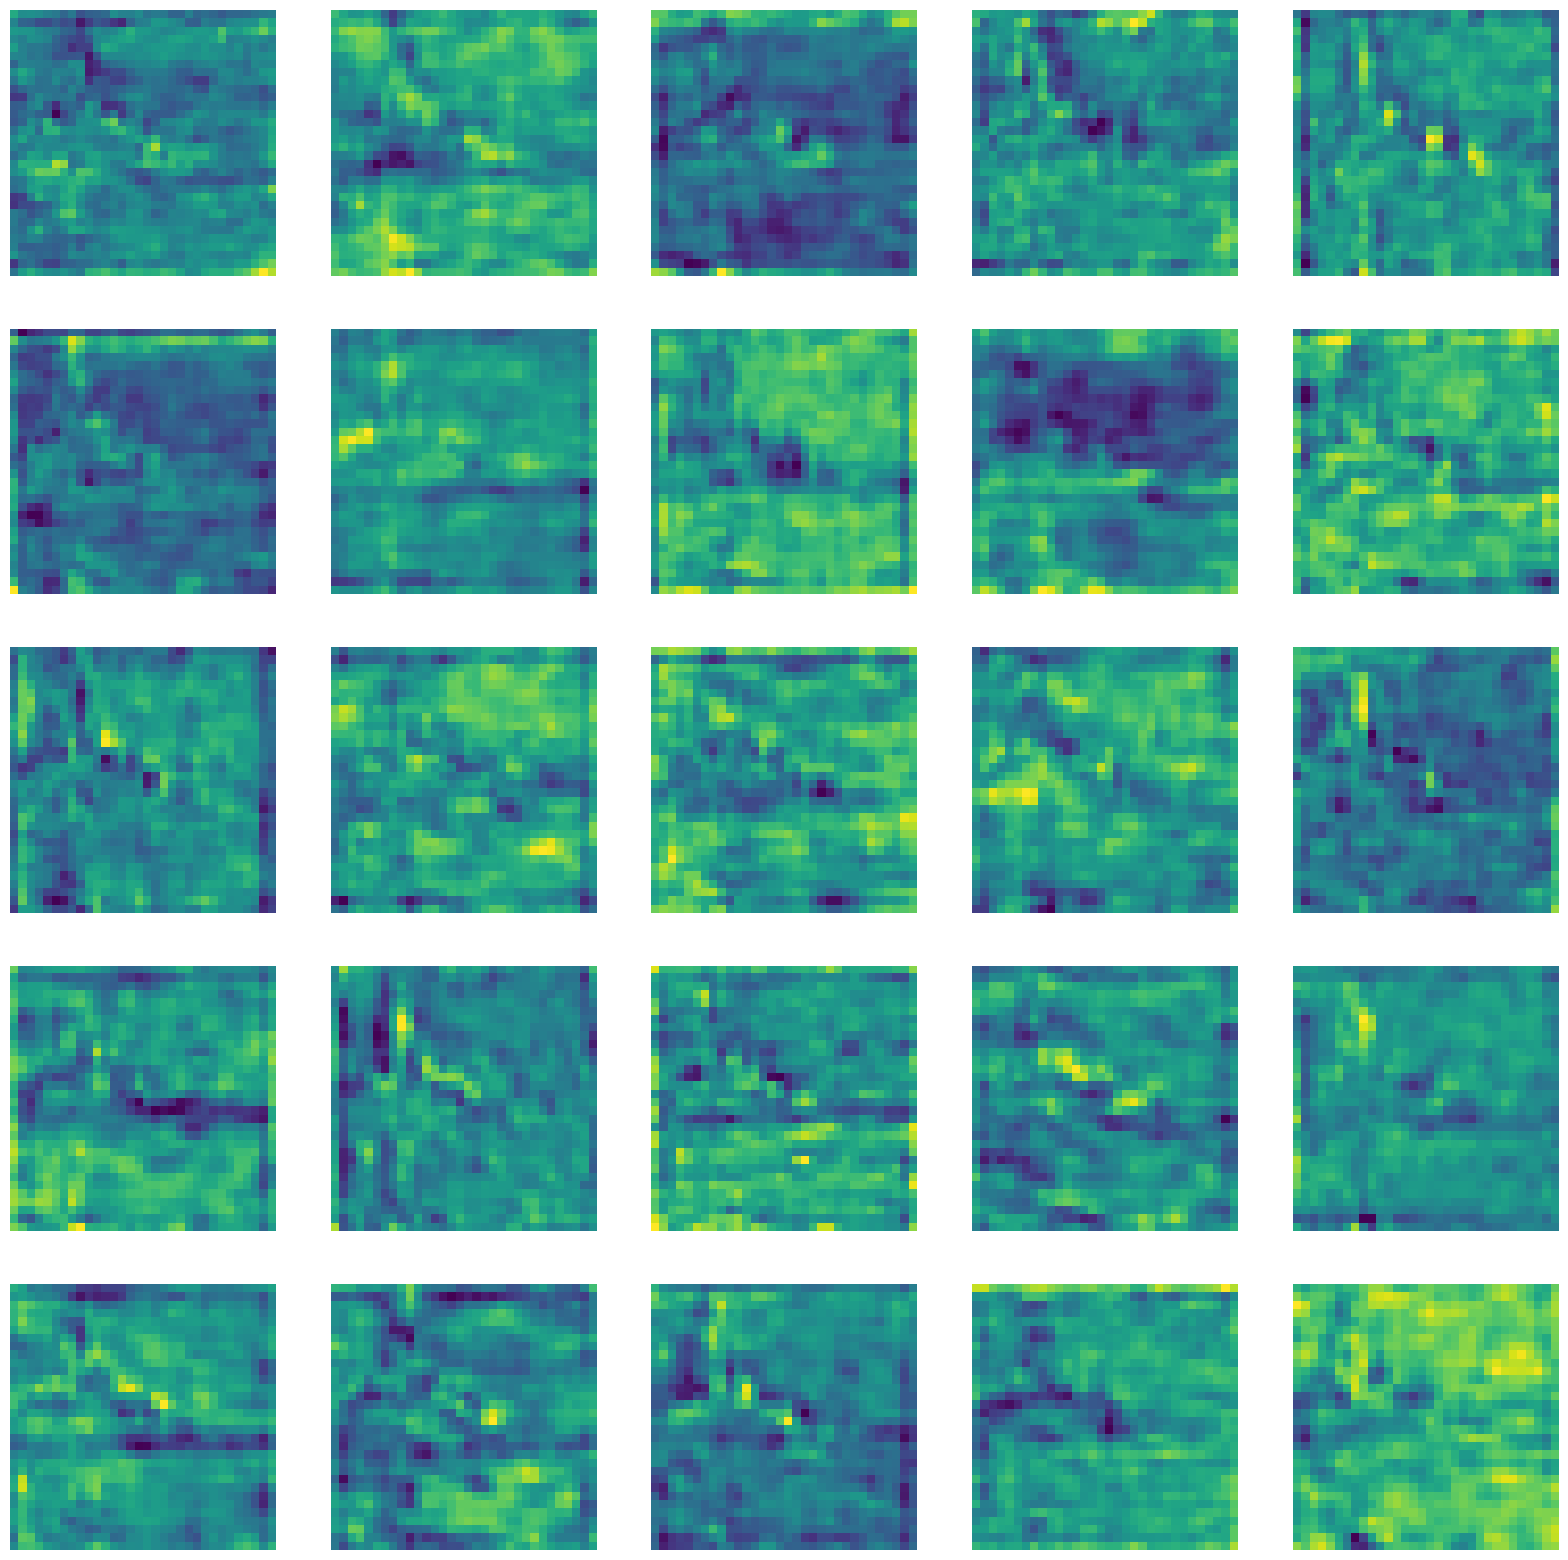

In [50]:
# Plot grid of the 25 first features
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(features[0, i].cpu().detach().numpy())
    plt.axis('off')

In [51]:
# Make a clustering of the features into K = 3 clusters then visualize the clusters with tSNE
features_view = features.view(features.shape[1], -1).cpu().detach().numpy()
print(features_view.shape)
kmeans = KMeans(n_clusters=3, random_state=0).fit(features_view.T)

(512, 1024)


In [27]:
features_embedded = TSNE(n_components=3, n_jobs=4, verbose=1, early_exaggeration=4).fit_transform(features_view.T)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4096 samples in 0.011s...
[t-SNE] Computed neighbors for 4096 samples in 0.228s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4096
[t-SNE] Computed conditional probabilities for sample 2000 / 4096
[t-SNE] Computed conditional probabilities for sample 3000 / 4096
[t-SNE] Computed conditional probabilities for sample 4000 / 4096
[t-SNE] Computed conditional probabilities for sample 4096 / 4096
[t-SNE] Mean sigma: 27.080468
[t-SNE] KL divergence after 250 iterations with early exaggeration: 18.530018
[t-SNE] KL divergence after 1000 iterations: 1.042696


In [28]:
import numpy as np
np.save("../data/misc/features_embedded2.npy", features_embedded)
np.save("../data/misc/kmeans2.npy", kmeans.labels_)

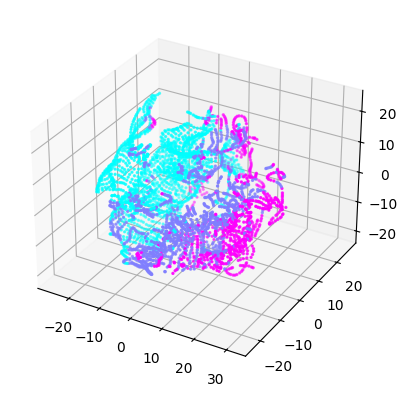

In [29]:
# Plot the clusters in 3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_embedded[:, 0], features_embedded[:, 1], features_embedded[:, 2], c=kmeans.labels_, cmap='cool', s=2)
plt.show()